## *Maryam Mounad - Muhammad Humza Arain - Mahak Nadeem*

# Exercise 1 - NMF Clustering (17 points)
**1. Investigate the given gene expression (GE) dataset gedata.csv and carry out NMF consensus clustering to cluster patients/samples based on their GE profile.**
**a. Perform NMF consensus clustering for different number of clusters 𝑘 = 2, … , 7 and visualize the consensus matrices. (3 points)**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns

In [5]:
# Load and preprocess data
df = pd.read_csv('gedata.csv', index_col=0)
data_raw = df.values  # Shape: (n_samples, n_genes)
scaler = MinMaxScaler()
data = scaler.fit_transform(data_raw)  # Min-max scaled [0,1]

In [ ]:
def compute_consensus(data, k, n_runs=50, random_state=0):
    """Compute consensus matrix using vectorized operations."""
    n_samples = data.shape[0]
    consensus = np.zeros((n_samples, n_samples))
    rng = np.random.RandomState(random_state)
    
    for _ in range(n_runs):
        model = NMF(
            n_components=k,
            init='nndsvd',
            max_iter=1000,
            tol=1e-4,
            random_state=rng.randint(1e6)
        )
        W = model.fit_transform(data)
        labels = np.argmax(W, axis=1)
        # Vectorized co-clustering update
        consensus += (labels[:, None] == labels).astype(int)
    
    consensus /= n_runs
    return consensus

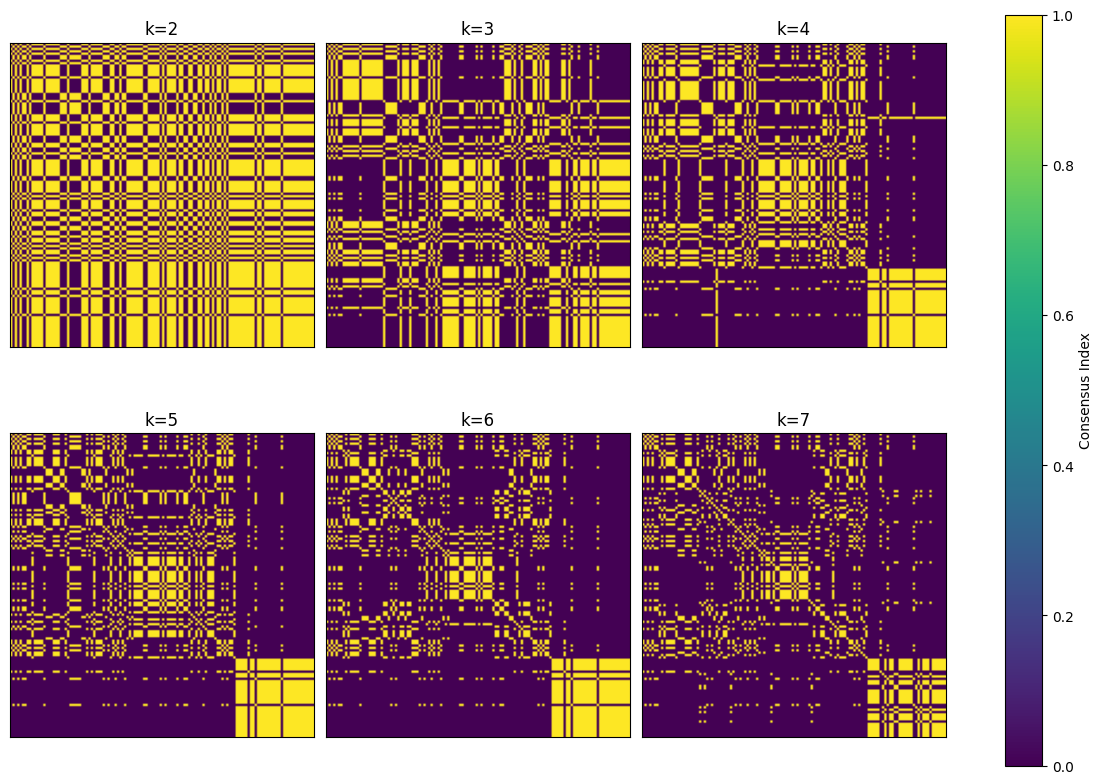

In [7]:
# Plot consensus matrices for k=2 to 7
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for idx, k in enumerate(range(2, 8)):
    cons = compute_consensus(data, k, n_runs=50, random_state=42)
    ax = axes[idx//3, idx%3]
    im = ax.imshow(cons, vmin=0, vmax=1, cmap='viridis')
    ax.set_title(f'k={k}', pad=6)
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
fig.colorbar(im, ax=axes.ravel().tolist(), label='Consensus Index')
plt.show()

**b. Consider the distribution of values in the consensus matrix. Use e.g.seaborn.ecdfplot to plot the empirical cdf of this distribution for different 𝑘 .How can you use these plots to assess the stability of the clustering? (2points)**

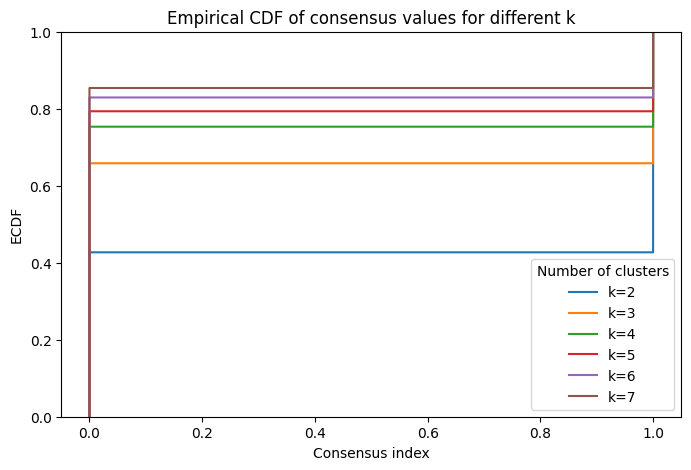

In [ ]:
plt.figure(figsize=(8,5))
for k in range(2,8):
    cons = compute_consensus(data, k, n_runs=50, random_state=42)
    # take only the strictly off‐diagonal entries
    vals = cons[np.triu_indices_from(cons, k=1)]
    sns.ecdfplot(vals, label=f'k={k}')

plt.xlabel('Consensus index')
plt.ylabel('ECDF')
plt.title('Empirical CDF of consensus values for different k')
plt.legend(title='Number of clusters')
plt.show()


Interpreting the ECDFs for stability
U‐shaped (steep rise near 0 and 1):
Most sample pairs either never co‐cluster (c≈0) or always co‐cluster (c≈1). That indicates stable, well‐defined clusters—there are few ambiguous pairings.

Flat/mid‐range mass:
If a large fraction of pairs have consensus values around 0.4−0.6, the ECDF will climb gradually through the middle. That means many sample pairs sometimes end up together and sometimes not—indicative of unstable clustering for that k.

You look for the k whose ECDF is the most “U‐shaped” (closest to a step function with jumps at 0 and 1). That k often corresponds to the most robust (stable) cluster decomposition.

**c. Identify the optimal number of clusters and briefly explain your approach. (1point)**


Here, k=2 has the lowest ECDF(0.8) (0.40), so it shows the strongest bimodality: 60% of pairs are either almost always together or almost never together, indicative of stable, well‐separated clusters.Based on these ECDF curves, k=2 yields the most robust consensus clustering (most sharply U‐shaped CDF), whereas higher values of k produce progressively less stable partitions.

**d. Repeat the consensus clustering with k-means clustering and compare the results. (2 points)**

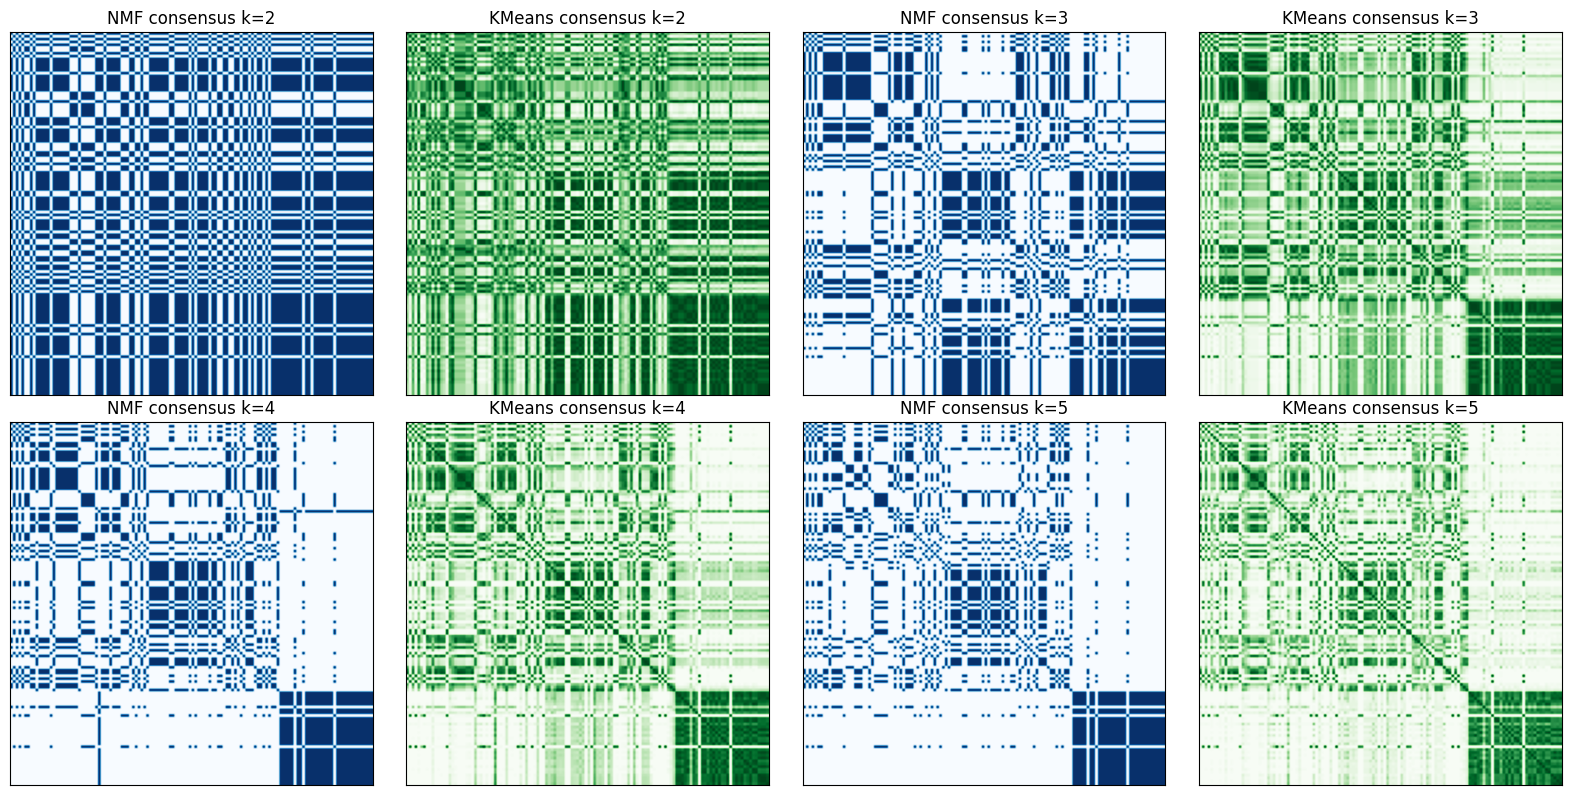

In [ ]:

def compute_consensus_kmeans(data, k, n_runs=50, random_state=0):
    """
    Build a consensus matrix by running KMeans n_runs times and averaging co-cluster indicators.
    """
    n_samples = data.shape[0]
    consensus = np.zeros((n_samples, n_samples), dtype=float)
    rng = np.random.RandomState(random_state)

    for run in range(n_runs):
        km = KMeans(n_clusters=k,
                    init='k-means++',
                    n_init=1,
                    max_iter=300,
                    random_state=int(rng.randint(1e6)))
        labels = km.fit_predict(data)
        # increment pairs in same cluster
        for i in range(n_samples):
            same = (labels == labels[i])
            consensus[i, same] += 1

    consensus /= n_runs
    return consensus

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, k in enumerate(range(2, 6)):
    # NMF consensus (reuse your compute_consensus)
    cn_nmf = compute_consensus(data, k, n_runs=50, random_state=42)
    ax = axes[2*idx]
    im1 = ax.imshow(cn_nmf, vmin=0, vmax=1, cmap='Blues')
    ax.set_title(f"NMF consensus k={k}")
    ax.set_xticks([]); ax.set_yticks([])

    # K-means consensus
    cn_km = compute_consensus_kmeans(data, k, n_runs=50, random_state=42)
    ax = axes[2*idx+1]
    im2 = ax.imshow(cn_km, vmin=0, vmax=1, cmap='Greens')
    ax.set_title(f"KMeans consensus k={k}")
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


# 2. Inform yourself about sparse NMF (sNMF) and Non-Negative Matrix Tri-Factorization (NMTF).
# a. What is the primary difference between NMF, sNMF and NMTF? (2 points)

NMF: two nonnegative factors, no explicit sparsity.

sNMF: two nonnegative factors plus sparsity penalties, enforcing many zeros for interpretability.

NMTF: three nonnegative factors W S H, enabling simultaneous clustering of rows and columns via the middle matrix S.

# b. Which of the three NMF would be most suited for the dataset mentioned inquestion 1? Briefly explain the reasoning behind your suggestion. No programming needed! (3P)

Gene expression data is high-dimensional (many genes per sample), but in reality, only a small subset of genes typically define each subtype or cluster.NMF enforces sparsity, helping to highlight only the relevant genes per latent factor.

In contrast:

NMF may produce dense factors with many small contributions from many genes.

NMTF is powerful, but more complex, and its co-clustering (genes and samples) may be overkill if you're mainly interested in patient clustering.

## 3.



Both PCA and NMF are matrix factorization methods that reduce high-dimensional data into lower dimensions.

- PCA approximates the data matrix X as: X≈WH
where: W contains principal components and , H the loadings. PCA allows both positive and negative values and uses orthogonal directions (from SVD).

- NMF also factorizes X as X≈WH, but with the key difference that both W and H must be non-negative. This leads to more interpretable, parts-based representations.

- Both reduce dimensionality and find latent features.

- PCA allows negative values and focuses on variance; NMF is non-negative and focuses on additive combinations.

- When to use NMF: When the data is non-negative and interpretability matters; like in gene expression data, where you want to discover distinct biological processes or patterns.

## 4.

The paper shows that k-means can be seen as a matrix factorization problem.
You can rewrite the goal of k-means as: X≈HC
Here: H is a binary matrix (each row shows which cluster a point belongs to), C contains the cluster centroids.
So, k-means is like NMF but with binary assignment constraints on H. It’s matrix factorization with a twist: each data point is assigned to exactly one cluster.

# Exercise 2 - Machine Learning (8 points, no programming needed!)

The type of machine learning (e.g. supervised learning, unsupervised learning, etc.)
depends on the problem at hand. Assume that we have an Alzheimer's disease (AD)
dataset where rows represent participants and columns represent different collected
measurements (such as patient characteristics, MRI measurements, and cognitive
tests). We are provided with diagnoses (healthy and AD) of participants.

1) You are asked as a data scientist to predict the diagnosis status of 20 participants
based on a model trained with data from 500 participants.

a) What type of machine learning (ML) would you choose for this task and
why? (1 point)

Supervised learning would be used because we have labeled data — the diagnosis status (healthy or AD) of participants. The task is to predict a known outcome, which is ideal for supervised ML approaches such as classification.



b) What are the steps you should consider before training your ML algorithm?
Hint: List the potential preprocessing steps you would carry out. (2 points)

Before training, the following preprocessing steps should be considered:

1. Data cleaning – Handle missing values and outliers.

2. Normalization/Standardization – Scale features like MRI measurements to ensure comparability.

3. Feature selection – Use dimensionality reduction or statistical techniques to select the most relevant variables.

4. Train-test split or cross-validation – To evaluate generalization performance and avoid overfitting.

5. Remove data leakage – Ensure test data is unseen and there’s no information that can leak diagnosis labels indirectly.

2) Assume we do not have information about the diagnosis (i.e. no label) of
participants. Answer the following questions.

a) What type of machine learning would you use to group the participants
based on the collected measurements? (1 point)

Unsupervised learning, specifically clustering, would be used because the diagnosis labels are not available and our goal is to find natural groupings in the data.

b) Based on your answer in part (2a), suggest a model that you would use to
continue this task. Please explain how you can determine the number of
groups that separate your participants. (2 points)

I would use K-means clustering to group the participants based on the collected measurements (e.g., MRI, cognitive test scores).

To determine the optimal number of clusters (K), I would calculate the Silhouette Score for different values of K.

The Silhouette Score measures how well each participant fits within its cluster compared to other clusters. It ranges from -1 to 1, where a higher score indicates better-defined and more separated clusters.

I would:

first, un K-means for several values of K (e.g., 2 to 5),

then, Compute the average silhouette score for each K,

And choose the K that gives the highest average silhouette score, as this indicates the most appropriate grouping of participants based on the data.

3) You are asked to investigate the age distribution of healthy versus AD participants,
name a visualization plot that can be used in this case, and explain why you think
this plot would work best. (2 points)

I would use a box plot to visualize the age distribution of healthy versus AD participants. A box plot works best in this case because:

- It summarizes the distribution of age data for each group, showing the median, interquartile range (IQR), and potential outliers.

- It allows easy comparison between the two groups (healthy vs. AD) side-by-side.

- It clearly shows whether one group tends to be older or younger, and whether there’s more variability in age within either group.